In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.graph_objects as go
import plotly.io as pio
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio

In [31]:

# Load the dataset
file_path_main = 'City_Pipe_Main.csv'  # Replace with the actual file path
city_pipe_main = pd.read_csv(file_path_main)

file_path_service = 'Service_Line_Table.csv'
service_line_table = pd.read_csv(file_path_service)

file_path_corrosion = 'Corrosion.csv'
Corrosion = pd.read_csv(file_path_corrosion)

file_path_house = 'House_Information.csv'
house_information = pd.read_csv(file_path_house)

file_path_pipe_information = 'Pipe_Information.csv'
pipe_information = pd.read_csv(file_path_pipe_information)

file_path_state_of_water = 'State_of_Water.csv'
state_of_water = pd.read_csv(file_path_state_of_water)

# Filter rows with valid coordinates in both datasets
city_pipe_main_valid = city_pipe_main.dropna(subset=['Latitude', 'Longitude'])
service_line_table_valid = service_line_table.dropna(subset=['Latitude', 'Longitude'])

In [29]:
def normalize(value, min_val, max_val):
    return (value - min_val) / (max_val - min_val)

corrosion_results = []

for index, row in Corrosion.iterrows():
    segment_id = row['SegmentID']

    pipe_data = pipe_information[pipe_information['SegmentID'] == segment_id].iloc[0]
    water_data = state_of_water[state_of_water['SegmentID'] == segment_id].iloc[0]
    
    diameter = pipe_data['Diameter (cm)']
    soil = pipe_data['Soil']
    ph_value = abs(water_data['PH-Value'])
    psi_level = abs(water_data['PSI Level'])
    water_temp = abs(water_data['Water Temperature'])
    
    if diameter == 30.48:
        mP, mPdev, F, mF, mFdev, fMax = 100, 100, 4700, 4700, 4700, 5405
    elif diameter == 4.1:
        mP, mPdev, F, mF, mFdev, fMax = 45, 85, 36.3, 36.3, 36.3, 41.75
    elif diameter == 3.5:
        mP, mPdev, F, mF, mFdev, fMax = 43, 87, 31, 31, 31, 35.7
    elif diameter == 2.7:
        mP, mPdev, F, mF, mFdev, fMax = 40, 90, 23.9, 23.9, 23.9, 27.49
    else:
        continue 
    
    ranges = {
        "A": (0, 14), "P": (0, 130), "mP": (0, mP), "mPdev": (0, mPdev),
        "T": (5, 15), "X": (2.7, 30.48), "F": (0, fMax), "mF": (0, mF),
        "mFdev": (0, mFdev), "S": (0, 1)
    }
    A = normalize(ph_value, *ranges["A"])
    P = normalize(psi_level, *ranges["P"])
    mP = normalize(mP, *ranges["mP"])
    T = normalize(water_temp, *ranges["T"])
    X = normalize(diameter, *ranges["X"])
    F = normalize(F, *ranges["F"])
    mF = normalize(mF, *ranges["mF"])
    mFdev = normalize(mFdev, *ranges["mFdev"])
    S = 0.7 if soil == "Clay" else 0.4
    S = normalize(S, *ranges["S"])
    I = 0.5
    
    Y = 40
    
    if pipe_data['Pipe Type'] == 'City Pipe Main':
        term1 = 0.16 * (0.3 + (A * (1 + 0.15)))
        term2 = 0.08 * (0.3 + (abs((P - mP)) * (0.6 + (1 / mPdev))))
        term3 = 0.16 * (T * (1 + 0.1))
        term4 = 0.08 * (X * (1 + 0.05))
        term5 = 0.16 * (0.3 + (abs((F - mF)) * (1 + (1 / mFdev))))
        term6 = 0.04 * (S * (1 + 0.1))
        term7 = 0.16 * (I * (1 + 0.1))
        #print("City Pipes Lines")
        #print(P)
        #print(f"Term 1: {term1} Term 2: {term2} Term 3: {term3} Term 4: {term4} Term 5: {term5} Term 6: {term6} Term 7: {term7}")
        corrosion_rate = 100 - (2.2 * Y * (term1 + term2 + term3 + term4 + term5 + term6 + term7))
    else:
        term1 = 0.16 * (0.3 + (A * (1 + 0.15)))
        term2 = 0.08 * (0.3 + (abs((P - mP)) * (1 + (1 / mPdev))))
        term3 = 0.16 * (T * (1 + 0.1))
        term4 = 0.08 * (X * (1 + 0.5))
        term5 = 0.16 * (0.3 + (abs((F - mF)) * (1 + (1 / mFdev))))
        term6 = 0.04 * (S * (1 + 0.1))
        term7 = 0.16 * (I * (1 + 0.1))
        #print("Service Lines")
        #print(P)
        #print(f"Term 1: {term1} Term 2: {term2} Term 3: {term3} Term 4: {term4} Term 5: {term5} Term 6: {term6} Term 7: {term7}")

        corrosion_rate = 100 - (2.2 * Y * (term1 + term2 + term3 + term4 + term5 + term6 + term7))
    
    # Determine corrosion level
    if 80 <= corrosion_rate <= 100:
        corrosion_level = 1
    elif 60 <= corrosion_rate < 80:
        corrosion_level = 2
    elif 40 <= corrosion_rate < 60:
        corrosion_level = 3
    elif 20 <= corrosion_rate < 40:
        corrosion_level = 4
    elif 0 <= corrosion_rate < 20:
        corrosion_level = 5
    elif corrosion_rate > 100:
        corrosion_level = "Pipe Healed???"
    else:
        corrosion_level = "Pipe corroded."
    
    # Store results
    corrosion_results.append({
        "SegmentID": segment_id,
        "CorrosionRate": corrosion_rate,
        "CorrosionLevel": corrosion_level
    })

corrosion_results_df = pd.DataFrame(corrosion_results)

# Merge the updated corrosion data back into the original Corrosion DataFrame
Corrosion.set_index('SegmentID', inplace=True)  # Set SegmentID as the index
corrosion_results_df.set_index('SegmentID', inplace=True)  # Align SegmentID indices

# Update the Corrosion DataFrame
Corrosion.update(corrosion_results_df[['CorrosionRate', 'CorrosionLevel']])  # Update only these columns

# Reset the index
Corrosion.reset_index(inplace=True)

# Save the updated Corrosion DataFrame to the CSV file
#Corrosion.to_csv("Corrosion.csv", index=False)
corrosion_results_df.head(100)

,CorrosionRate,CorrosionLevel
SegmentID,,
57a63f0e-7c18-487b-99d1-5be36bdaf0a5,54.326475,3
57954d55-957a-4144-bce1-b582417f7bd3,49.979233,3
9be18c15-ee70-4de6-999b-b4d6f487dd9c,54.461145,3
8317d426-99fb-4175-9d9c-7b2c015d5762,51.059873,3
381ba406-9841-4c7e-85d7-59180f19b14a,54.557789,3
b38c419d-0f19-4975-8d7a-d3ff8a77ecbd,51.517473,3
e119faae-ae74-4da6-9e26-8c826a383c58,53.048126,3
a8414705-99ee-4986-b13d-16a8a7b302ab,51.904170,3
70f14523-2812-475a-b7fd-a007d034faa8,53.952253,3


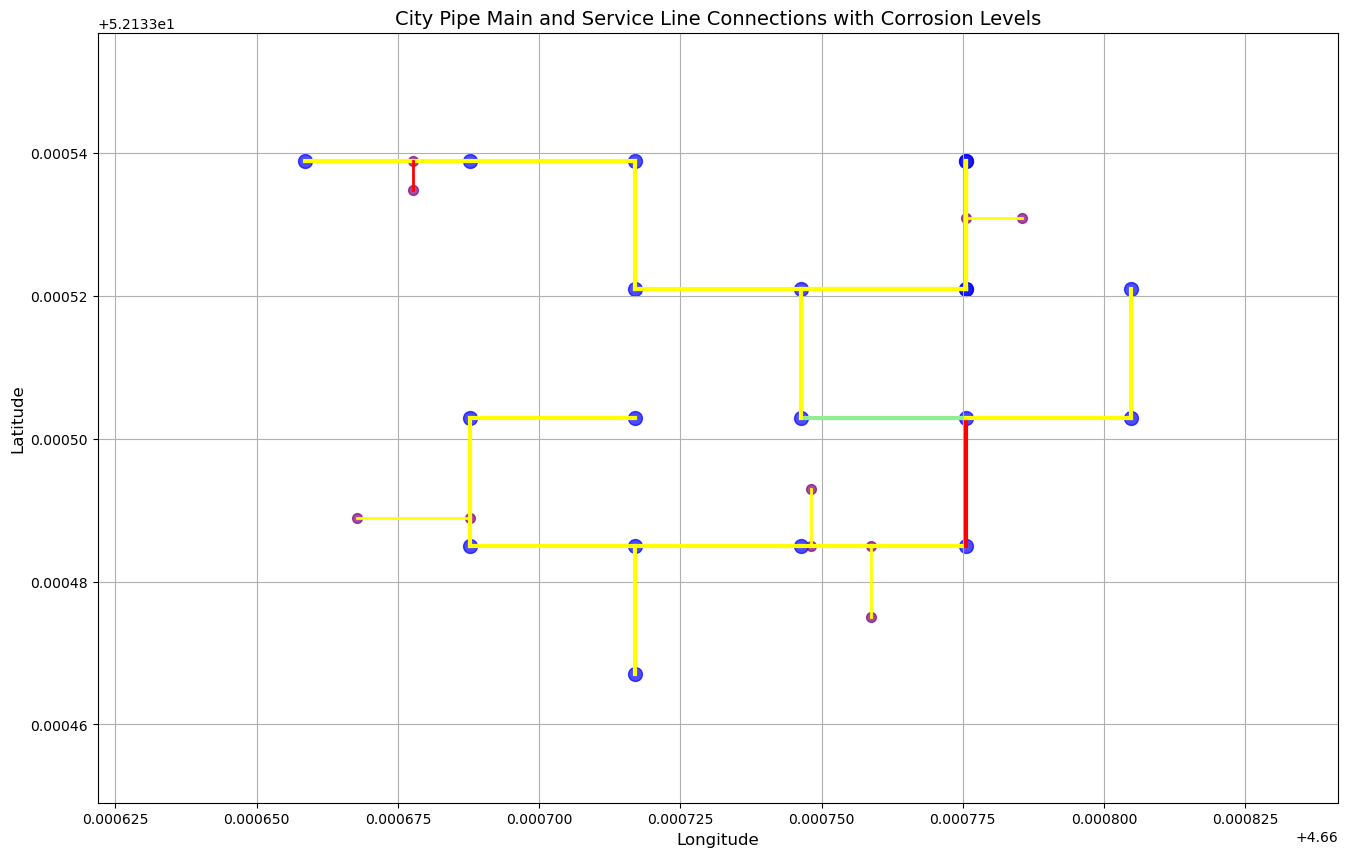

In [32]:
# Define corrosion colors
corrosion_colors = {
    1: 'darkgreen',
    2: 'lightgreen',
    3: 'yellow',
    4: 'orange',
    5: 'red'
}
corrosion_map = Corrosion.set_index('SegmentID')['CorrosionLevel'].to_dict()

city_edges = []
city_positions = {}

for _, row in city_pipe_main.iterrows():
    city_positions[row['SegmentID']] = (row['Longitude'], row['Latitude'])
    if pd.notna(row['Parent Pipe']):
        parent_row = city_pipe_main[city_pipe_main['SegmentID'] == row['Parent Pipe']]
        if not parent_row.empty:
            parent_lat, parent_lon = parent_row.iloc[0]['Latitude'], parent_row.iloc[0]['Longitude']
            corrosion_level = corrosion_map.get(row['SegmentID'], None)
            color = corrosion_colors.get(corrosion_level, 'gray')  # Default to gray if no corrosion level
            city_edges.append(((parent_lon, parent_lat), (row['Longitude'], row['Latitude']), color))

service_edges = []
service_positions = {}

for _, row in service_line_table.iterrows():
    service_positions[row['SegmentID']] = (row['Longitude'], row['Latitude'])
    if pd.notna(row['ParentPipe']):
        parent_row = service_line_table[service_line_table['SegmentID'] == row['ParentPipe']]
        if not parent_row.empty:
            parent_lat, parent_lon = parent_row.iloc[0]['Latitude'], parent_row.iloc[0]['Longitude']
            corrosion_level = corrosion_map.get(row['SegmentID'], None)
            color = corrosion_colors.get(corrosion_level, 'gray')  # Default to gray if no corrosion level
            service_edges.append(((parent_lon, parent_lat), (row['Longitude'], row['Latitude']), color))

combined_latitudes = pd.concat([city_pipe_main['Latitude'], service_line_table['Latitude']])
combined_longitudes = pd.concat([city_pipe_main['Longitude'], service_line_table['Longitude']])

center_lon = (combined_longitudes.max() + combined_longitudes.min()) / 2
center_lat = (combined_latitudes.max() + combined_latitudes.min()) / 2
lon_range = combined_longitudes.max() - combined_longitudes.min()
lat_range = combined_latitudes.max() - combined_latitudes.min()
zoom_factor = 1.5

plt.figure(figsize=(16, 10))

for edge in city_edges:
    x_coords = [edge[0][0], edge[1][0]]
    y_coords = [edge[0][1], edge[1][1]]
    plt.plot(x_coords, y_coords, color=edge[2], linewidth=3, label='City Pipe Main Edge')

for edge in service_edges:
    x_coords = [edge[0][0], edge[1][0]]
    y_coords = [edge[0][1], edge[1][1]]
    plt.plot(x_coords, y_coords, color=edge[2], linewidth=2, label='Service Line Edge')

for node, (lon, lat) in city_positions.items():
    plt.scatter(lon, lat, s=100, alpha=0.7, color='blue', label='City Pipe Main Node')

for node, (lon, lat) in service_positions.items():
    plt.scatter(lon, lat, s=50, alpha=0.7, color='purple', label='Service Line Node')

plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.title("City Pipe Main and Service Line Connections with Corrosion Levels", fontsize=14)

plt.xlim(center_lon - (lon_range / 2 * zoom_factor), center_lon + (lon_range / 2 * zoom_factor))
plt.ylim(center_lat - (lat_range / 2 * zoom_factor), center_lat + (lat_range / 2 * zoom_factor))

plt.grid(True)
plt.show()

In [ ]:
# Set the default renderer to open in the browser
pio.renderers.default = 'browser'

# File paths
file_path_main = 'City_Pipe_Main.csv'  # Main file
file_path_service = 'Service_Line_Table.csv'  # Service line file
file_path_corrosion = 'Corrosion.csv'  # Corrosion data file

# Load the datasets
city_pipe_main = pd.read_csv(file_path_main)
service_line_table = pd.read_csv(file_path_service)
corrosion_data = pd.read_csv(file_path_corrosion)

# Select only necessary columns from Corrosion
corrosion_filtered = corrosion_data[['SegmentID', 'CorrosionLevel', 'CorrosionRate']]

# Merge Corrosion data into City_Pipe_Main
city_pipe_main_merged = pd.merge(city_pipe_main, corrosion_filtered, on='SegmentID', how='left')

# Merge Corrosion data into Service_Line_Table
service_line_table_merged = pd.merge(service_line_table, corrosion_filtered, on='SegmentID', how='left')

# Randomize CorrosionLevel between 1 and 5 for both datasets
# city_pipe_main_merged['CorrosionLevel'] = np.random.randint(1, 6, size=len(city_pipe_main_merged))
#service_line_table_merged['CorrosionLevel'] = np.random.randint(1, 6, size=len(service_line_table_merged))

# Randomize CorrosionRate (for demonstration, using a random float between 0 and 100)
#city_pipe_main_merged['CorrosionRate'] = np.random.uniform(0, 100, size=len(city_pipe_main_merged))
#service_line_table_merged['CorrosionRate'] = np.random.uniform(0, 100, size=len(service_line_table_merged))

# Save the updated datasets
city_pipe_main_merged.to_csv('City_Pipe_Main_Updated.csv', index=False)
service_line_table_merged.to_csv('Service_Line_Table_Updated.csv', index=False)

# Filter rows with valid coordinates
city_pipe_main_valid = city_pipe_main_merged.dropna(subset=['Latitude', 'Longitude'])
service_line_table_valid = service_line_table_merged.dropna(subset=['Latitude', 'Longitude'])

# Define corrosion colors
corrosion_colors = {
    1: 'darkgreen',
    2: 'lightgreen',
    3: 'yellow',
    4: 'orange',
    5: 'red'
}

# Generate unique color mappings for directions
all_directions = pd.concat([city_pipe_main_valid['Direction'], service_line_table_valid['Direction']]).unique()
direction_colors = {direction: f"rgb({(i * 50) % 255}, {(i * 100) % 255}, {(i * 150) % 255})" for i, direction in enumerate(all_directions)}

# Process edges and nodes for City Pipe Main
city_edges = []
city_positions = {}
city_edge_hover_texts = []

for _, row in city_pipe_main_valid.iterrows():
    city_positions[row['SegmentID']] = (row['Longitude'], row['Latitude'])
    corrosion_level = row['CorrosionLevel']
    corrosion_color = corrosion_colors.get(corrosion_level, 'gray')  # Default to gray if no corrosion level
    
    if pd.notna(row['Parent Pipe']):
        parent_row = city_pipe_main_valid[city_pipe_main_valid['SegmentID'] == row['Parent Pipe']]
        if not parent_row.empty:
            parent_lat, parent_lon = parent_row.iloc[0]['Latitude'], parent_row.iloc[0]['Longitude']
            parent_hover_text = "<br>".join([f"{col}: {parent_row.iloc[0][col]}" for col in ['Longitude', 'Latitude', 'CorrosionLevel', 'CorrosionRate']])
            node_hover_text = "<br>".join([f"{col}: {row[col]}" for col in ['Longitude', 'Latitude', 'CorrosionLevel', 'CorrosionRate']])
            city_edges.append(((parent_lon, parent_lat), (row['Longitude'], row['Latitude']), corrosion_color))
            city_edge_hover_texts.append(f"Start:<br>{parent_hover_text}<br><br>End:<br>{node_hover_text}")

# Process edges and nodes for Service Line Table
service_edges = []
service_positions = {}
service_edge_hover_texts = []

for _, row in service_line_table_valid.iterrows():
    service_positions[row['SegmentID']] = (row['Longitude'], row['Latitude'])
    corrosion_level = row['CorrosionLevel']
    corrosion_color = corrosion_colors.get(corrosion_level, 'gray')  # Default to gray if no corrosion level
    
    if pd.notna(row['ParentPipe']):
        parent_row_main = city_pipe_main_valid[city_pipe_main_valid['SegmentID'] == row['ParentPipe']]
        parent_row_service = service_line_table_valid[service_line_table_valid['SegmentID'] == row['ParentPipe']]
        parent_row = pd.concat([parent_row_main, parent_row_service])

        if not parent_row.empty:
            parent_lat, parent_lon = parent_row.iloc[0]['Latitude'], parent_row.iloc[0]['Longitude']
            parent_hover_text = "<br>".join([f"{col}: {parent_row.iloc[0][col]}" for col in ['Longitude', 'Latitude', 'CorrosionLevel', 'CorrosionRate']])
            node_hover_text = "<br>".join([f"{col}: {row[col]}" for col in ['Longitude', 'Latitude', 'CorrosionLevel', 'CorrosionRate']])
            service_edges.append(((parent_lon, parent_lat), (row['Longitude'], row['Latitude']), corrosion_color))
            service_edge_hover_texts.append(f"Start:<br>{parent_hover_text}<br><br>End:<br>{node_hover_text}")

# Combine latitudes and longitudes for centering
combined_latitudes = pd.concat([city_pipe_main_valid['Latitude'], service_line_table_valid['Latitude']])
combined_longitudes = pd.concat([city_pipe_main_valid['Longitude'], service_line_table_valid['Longitude']])

center_lon = (combined_longitudes.max() + combined_longitudes.min()) / 2
center_lat = (combined_latitudes.max() + combined_latitudes.min()) / 2
lon_range = combined_longitudes.max() - combined_longitudes.min()
lat_range = combined_latitudes.max() - combined_latitudes.min()

# Adjust zoom factor
zoom_factor = 1.5

# Create the plotly figure with mapbox
fig = go.Figure()

# Add edges for City Pipe Main with mapbox and color transitions
for edge, hover_text in zip(city_edges, city_edge_hover_texts):
    x_start, x_end = edge[0][0], edge[1][0]
    y_start, y_end = edge[0][1], edge[1][1]
    
    fig.add_trace(go.Scattermapbox(
        lon=[x_start, x_end],
        lat=[y_start, y_end],
        mode='lines',
        line=dict(color=edge[2], width=5),  # Thicker solid lines for city pipes, colored based on corrosion level
        text=hover_text, hoverinfo='text',
        showlegend=False
    ))

# Add edges for Service Line with mapbox and thinner lines
for edge, hover_text in zip(service_edges, service_edge_hover_texts):
    x_start, x_end = edge[0][0], edge[1][0]
    y_start, y_end = edge[0][1], edge[1][1]
    
    fig.add_trace(go.Scattermapbox(
        lon=[x_start, x_end],
        lat=[y_start, y_end],
        mode='lines',
        line=dict(color=edge[2], width=3),  # Thinner lines for service pipes, colored based on corrosion level
        text=hover_text, hoverinfo='text',
        showlegend=False
    ))

# Add nodes for City Pipe Main with mapbox
for segment_id, (lon, lat) in city_positions.items():
    row = city_pipe_main_valid[city_pipe_main_valid['SegmentID'] == segment_id].iloc[0]
    corrosion_level = row['CorrosionLevel']
    corrosion_color = corrosion_colors.get(corrosion_level, 'gray')  # Default to gray if no corrosion level
    hover_text = "<br>".join([f"{col}: {row[col]}" for col in ['Longitude', 'Latitude', 'CorrosionLevel', 'CorrosionRate']])
    fig.add_trace(go.Scattermapbox(
        lon=[lon], lat=[lat], mode='markers',
        marker=dict(size=10, color=corrosion_color),
        text=hover_text, hoverinfo='text',
        showlegend=False
    ))

# Add nodes for Service Line Table with mapbox
for segment_id, (lon, lat) in service_positions.items():
    row = service_line_table_valid[service_line_table_valid['SegmentID'] == segment_id].iloc[0]
    corrosion_level = row['CorrosionLevel']
    corrosion_color = corrosion_colors.get(corrosion_level, 'gray')  # Default to gray if no corrosion level
    hover_text = "<br>".join([f"{col}: {row[col]}" for col in ['Longitude', 'Latitude', 'CorrosionLevel', 'CorrosionRate']])
    fig.add_trace(go.Scattermapbox(
        lon=[lon], lat=[lat], mode='markers',
        marker=dict(size=7, color=corrosion_color),
        text=hover_text, hoverinfo='text',
        showlegend=False
    ))

# Set map layout properties
fig.update_layout(
    mapbox_style="open-street-map",  # Use Open Street Map as the background
    mapbox_center={"lon": center_lon, "lat": center_lat},
    mapbox_zoom=12,
    title="Interactive City Pipe Main and Service Line Connections",
    showlegend=False,
    template="plotly_white",
    autosize=True
)

# Show the interactive plot on the map
fig.show()

